# Downloading Dataset

In [1]:
!gdown https://drive.google.com/uc?id=1oGR3D3-2rVADdp4HdmnjSNDS3bKCThog
!7z x Dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1oGR3D3-2rVADdp4HdmnjSNDS3bKCThog
From (redirected): https://drive.google.com/uc?id=1oGR3D3-2rVADdp4HdmnjSNDS3bKCThog&confirm=t&uuid=f84ad954-b201-4081-8da6-8481d1c3a9f0
To: /content/Dataset.zip
100% 61.0M/61.0M [00:01<00:00, 36.1MB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 60994498 bytes (59 MiB)

Extracting archive: Dataset.zip
--
Path = Dataset.zip
Type = zip
Physical Size = 60994498

  0%      3% 9 - UCI HAR Dataset/test/Inertial Signals/body_acc_y_test.txt                                                                    9% 12 - UCI HAR Dataset/test

Importing Required Libraries

In [206]:
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats import entropy, iqr
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

Reading train and test files as Pandas DataFrame

In [180]:

X_train = pd.read_csv('/content/UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('/content/UCI HAR Dataset/train/y_train.txt', header=None)
X_test = pd.read_csv('/content/UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('/content/UCI HAR Dataset/test/y_test.txt', header=None)


<ipython-input-180-2c722ebcf0af>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('/content/UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
<ipython-input-180-2c722ebcf0af>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('/content/UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)


In [33]:
# convert all X_train,y_train,X_test,y_test to csv for next use

X_train.to_csv('/content/X_train.csv', index=False)
y_train.to_csv('/content/y_train.csv', index=False)
X_test.to_csv('/content/X_test.csv', index=False)
y_test.to_csv('/content/y_test.csv', index=False)


# Preprocessing and Analysis

In [181]:
X_train.info()

# 7352 Rows and 561 Features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, 0 to 560
dtypes: float64(561)
memory usage: 31.5 MB


In [182]:
print(X_train.isna().sum())
print("\n\nTotal NA values:", X_train.isna().sum().sum())


# No NaN valuesm

0      0
1      0
2      0
3      0
4      0
      ..
556    0
557    0
558    0
559    0
560    0
Length: 561, dtype: int64


Total NA values: 0


In [183]:
print(y_train[0].value_counts(), "\n\n")
print(y_test[0].value_counts())


#Y Label seems distribute somewhat evenly so not much bias

0
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64 


0
6    537
5    532
1    496
4    491
2    471
3    420
Name: count, dtype: int64


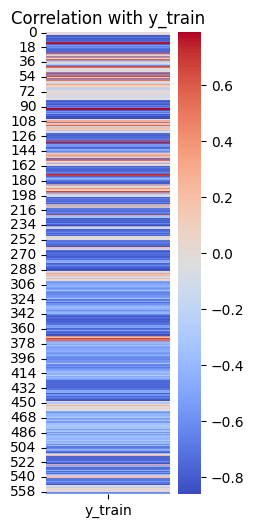

In [184]:
# Plotting Correlation of y with all features to select prominent features only

X_train_df = pd.DataFrame(X_train)
X_train_df['y_train'] = y_train
correlation_matrix = X_train_df.corr()
correlation_with_y = correlation_matrix['y_train'].drop('y_train')

# Plotting the correlations
plt.figure(figsize=(2, 6))
sns.heatmap(correlation_with_y.to_frame(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with y_train')
plt.show()

In [185]:
features_to_drop = correlation_with_y[(correlation_with_y < 0.25) & (correlation_with_y > -0.25)].index
print(len(features_to_drop))
X_train_dropped = pd.DataFrame(X_train).drop(columns=features_to_drop)
X_test_dropped = pd.DataFrame(X_test).drop(columns=features_to_drop)
# 111 Features Dropped

111


In [186]:
scaler = StandardScaler()
X_train_dropped = scaler.fit_transform(X_train_dropped)
X_test_dropped = scaler.transform(X_test_dropped)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# **Trying Random Forest as many features**

Model without dropping Columns

In [150]:

model2 = RandomForestClassifier(n_estimators=100, random_state=42)


In [151]:

model2.fit(X_train, y_train.values.ravel())


RandomForestClassifier(random_state=42)

In [194]:
# Score of our Dataset without dropping values
test_y_pred = model2.predict(X_test)

print("Testing Classification Report:")
print(classification_report(y_test, test_y_pred))

# 93% Accuracy achieved

Testing Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.97      0.93       496
           2       0.90      0.89      0.90       471
           3       0.96      0.87      0.91       420
           4       0.91      0.90      0.90       491
           5       0.91      0.92      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947



In [153]:
print("Confusion Matrix for testing:")
print(confusion_matrix(y_test, test_y_pred))

Confusion Matrix for testing:
[[480   9   7   0   0   0]
 [ 43 421   7   0   0   0]
 [ 17  39 364   0   0   0]
 [  0   0   0 441  50   0]
 [  0   0   0  44 488   0]
 [  0   0   0   0   0 537]]


Random Forest Model with dropping Columns

In [154]:

model = RandomForestClassifier(n_estimators=100, random_state=42)


In [155]:

model.fit(X_train_dropped, y_train.values.ravel())


RandomForestClassifier(random_state=42)

In [195]:
# Score of our Dataset with dropping values of low correlation with y
test_y_pred = model.predict(X_test_dropped)


print("Testing Classification Report:")
print(classification_report(y_test, test_y_pred))

# 93% Accuracy achieved

Testing Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.96      0.92       496
           2       0.87      0.90      0.88       471
           3       0.97      0.83      0.90       420
           4       0.92      0.91      0.91       491
           5       0.92      0.93      0.92       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.93      0.93      2947



#### Recieved Similar result even after dropping some columns, better classification for 4,5 class but worse for 2,3.

In [158]:

print("Confusion Matrix for testing:")
print(confusion_matrix(y_test, test_y_pred))

Confusion Matrix for testing:
[[477  14   5   0   0   0]
 [ 42 423   6   0   0   0]
 [ 19  51 350   0   0   0]
 [  0   0   0 446  45   0]
 [  0   0   0  38 494   0]
 [  0   0   0   0   0 537]]


# **Trying SVM**

In [192]:
# SVM Model without dropping Columns
svm_model2 = SVC(kernel='linear', C=1)  # You can adjust the kernel and C parameter
svm_model2.fit(X_train, y_train.values.ravel())
svm_test_y_pred2 = svm_model2.predict(X_test)
print("SVM (No Dropping) Classification Report:")
print(classification_report(y_test, svm_test_y_pred2))


# SVM Model with dropping Columns
svm_model = SVC(kernel='linear', C=1)  # You can adjust the kernel and C parameter
svm_model.fit(X_train_dropped, y_train.values.ravel())
svm_test_y_pred = svm_model.predict(X_test_dropped)
print("SVM (With Dropping) Classification Report:")
print(classification_report(y_test, svm_test_y_pred))

SVM (No Dropping) Classification Report:
              precision    recall  f1-score   support

           1       0.96      1.00      0.98       496
           2       0.96      0.96      0.96       471
           3       0.99      0.95      0.97       420
           4       0.96      0.88      0.92       491
           5       0.90      0.97      0.93       532
           6       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

SVM (With Dropping) Classification Report:
              precision    recall  f1-score   support

           1       0.93      1.00      0.96       496
           2       0.96      0.93      0.95       471
           3       1.00      0.95      0.98       420
           4       0.96      0.85      0.90       491
           5       0.88      0.97      0.92       532
           6       1.00      1.00      1.00     

#### Got 95% accuracy. Better than Random Forest.
Also tried other kernel function but linear is giving best results.

# **Trying custom Data from Physics ToolBox**

In [196]:
!gdown https://drive.google.com/uc?id=1R2wNRjZpLBd3pQmi6uNbDQAdkR8b_nqf

Downloading...
From: https://drive.google.com/uc?id=1R2wNRjZpLBd3pQmi6uNbDQAdkR8b_nqf
To: /content/check.csv
100% 175k/175k [00:00<00:00, 4.35MB/s]


In [210]:
data = pd.read_csv('/content/check.csv')
# I was actually sitting while creating this dataset so the true y label would be 4.

In [211]:
data.head()

,time,gFx,gFy,gFz,TgF
0,0.004952,-0.0689,0.1864,0.9684,0.989
1,0.005533,-0.0682,0.1771,0.9596,0.978
2,0.005963,-0.0699,0.1695,0.9508,0.968
3,0.006235,-0.0708,0.1622,0.9423,0.959
4,0.006416,-0.0726,0.1561,0.9325,0.948


Converting the Data from Physics Tool App to dataset form for our model consisting of same number of feature as on which the model was trained

In [216]:
# Helper functions to compute features
def calculate_mean(series):
    return series.mean()

def calculate_std(series):
    return series.std()

def calculate_mad(series):
    median = series.median()
    return (np.abs(series - median)).median()

def calculate_max(series):
    return series.max()

def calculate_min(series):
    return series.min()

def calculate_sma(df):
    return (df['gFx'].abs() + df['gFy'].abs() + df['gFz'].abs()).sum() / len(df)

def calculate_energy(series):
    return (series**2).sum() / len(series)

def calculate_iqr(series):
    return iqr(series)

def calculate_entropy(series):
    hist, _ = np.histogram(series, bins=10, density=True)
    return entropy(hist)

def calculate_ar_coefficients(series, order=4):
    model = AutoReg(series, lags=order, old_names=False).fit()
    return model.params

def calculate_correlation(series1, series2):
    return series1.corr(series2)

def calculate_magnitude(df, cols=['gFx', 'gFy', 'gFz']):
    return np.sqrt(sum(df[col]**2 for col in cols))

def calculate_fft_features(series):
    series_np = series.to_numpy()
    fft_vals = fft(series_np)
    mean_freq = np.mean(np.abs(fft_vals))
    max_freq = np.argmax(np.abs(fft_vals))
    return mean_freq, max_freq


def calculate_band_energy(series, low, high, fs=50):
    series_np = series.to_numpy()
    fft_vals = fft(series_np)
    freq_bins = np.fft.fftfreq(len(series_np), d=1/fs)
    band_power = sum(np.abs(fft_vals[(freq_bins >= low) & (freq_bins <= high)])**2)
    return band_power


# Initialize feature dictionary
features = {}

# Calculate time-domain features for tBodyAcc and tGravityAcc
for axis in ['gFx', 'gFy', 'gFz']:
    features[f'tBodyAcc-mean()-{axis[-1]}'] = calculate_mean(data[axis])
    features[f'tBodyAcc-std()-{axis[-1]}'] = calculate_std(data[axis])
    features[f'tBodyAcc-mad()-{axis[-1]}'] = calculate_mad(data[axis])
    features[f'tBodyAcc-max()-{axis[-1]}'] = calculate_max(data[axis])
    features[f'tBodyAcc-min()-{axis[-1]}'] = calculate_min(data[axis])
    features[f'tBodyAcc-energy()-{axis[-1]}'] = calculate_energy(data[axis])
    features[f'tBodyAcc-iqr()-{axis[-1]}'] = calculate_iqr(data[axis])
    features[f'tBodyAcc-entropy()-{axis[-1]}'] = calculate_entropy(data[axis])

    ar_coeffs = calculate_ar_coefficients(data[axis])
    for i, coeff in enumerate(ar_coeffs[1:], start=1):
        features[f'tBodyAcc-arCoeff()-{axis[-1]},{i}'] = coeff

# SMA across all three axes
features['tBodyAcc-sma()'] = calculate_sma(data)



# Correlations between axes
features['tBodyAcc-correlation()-X,Y'] = calculate_correlation(data['gFx'], data['gFy'])
features['tBodyAcc-correlation()-X,Z'] = calculate_correlation(data['gFx'], data['gFz'])
features['tBodyAcc-correlation()-Y,Z'] = calculate_correlation(data['gFy'], data['gFz'])


# Calculate magnitude for gravity and body acceleration
features['tBodyAccMag-mean()'] = calculate_mean(calculate_magnitude(data))

# Frequency-based features
for axis in ['gFx', 'gFy', 'gFz']:
    mean_freq, max_freq = calculate_fft_features(data[axis])
    features[f'fBodyAcc-meanFreq()-{axis[-1]}'] = mean_freq
    features[f'fBodyAcc-maxInds-{axis[-1]}'] = max_freq


# Calculate jerk as the difference between consecutive data points
data['gFx_jerk'] = data['gFx'].diff().fillna(0)
data['gFy_jerk'] = data['gFy'].diff().fillna(0)
data['gFz_jerk'] = data['gFz'].diff().fillna(0)


data['tBodyAccMag'] = calculate_magnitude(data, ['gFx', 'gFy', 'gFz'])
data['tBodyAccJerkMag'] = calculate_magnitude(data, ['gFx_jerk', 'gFy_jerk', 'gFz_jerk'])

def calculate_angle(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norms = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    return np.arccos(dot_product / norms)

features['angle(tBodyAccMean,gravity)'] = calculate_angle(data[['gFx', 'gFy', 'gFz']].mean(), [0, 0, 1])


for axis in ['gFx', 'gFy', 'gFz']:
    features[f'fBodyAcc-bandsEnergy()-1,8-{axis[-1]}'] = calculate_band_energy(data[axis], 1, 8)
    features[f'fBodyAcc-bandsEnergy()-9,16-{axis[-1]}'] = calculate_band_energy(data[axis], 9, 16)
    features[f'fBodyAcc-bandsEnergy()-17,24-{axis[-1]}'] = calculate_band_energy(data[axis], 17,24)
    features[f'fBodyAcc-bandsEnergy()-25,32-{axis[-1]}'] = calculate_band_energy(data[axis], 25,32)
    features[f'fBodyAcc-bandsEnergy()-33,40-{axis[-1]}'] = calculate_band_energy(data[axis], 33,40)
    features[f'fBodyAcc-bandsEnergy()-41,48-{axis[-1]}'] = calculate_band_energy(data[axis], 41,48)
    features[f'fBodyAcc-bandsEnergy()-49,56-{axis[-1]}'] = calculate_band_energy(data[axis], 49,56)
    features[f'fBodyAcc-bandsEnergy()-57,64-{axis[-1]}'] = calculate_band_energy(data[axis], 57,64)
    features[f'fBodyAcc-bandsEnergy()-1,16-{axis[-1]}'] = calculate_band_energy(data[axis], 1,16)
    features[f'fBodyAcc-bandsEnergy()-17,32-{axis[-1]}'] = calculate_band_energy(data[axis], 17,32)
    features[f'fBodyAcc-bandsEnergy()-33,48-{axis[-1]}'] = calculate_band_energy(data[axis], 33,48)
    features[f'fBodyAcc-bandsEnergy()-49,64-{axis[-1]}'] = calculate_band_energy(data[axis],49,64)
    features[f'fBodyAcc-bandsEnergy()-1,24-{axis[-1]}'] = calculate_band_energy(data[axis], 1,24)
    features[f'fBodyAcc-bandsEnergy()-25,48-{axis[-1]}'] = calculate_band_energy(data[axis], 25,48)




# Convert dictionary to DataFrame and save
features_df = pd.DataFrame([features])



In [217]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 90 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tBodyAcc-mean()-x               1 non-null      float64
 1   tBodyAcc-std()-x                1 non-null      float64
 2   tBodyAcc-mad()-x                1 non-null      float64
 3   tBodyAcc-max()-x                1 non-null      float64
 4   tBodyAcc-min()-x                1 non-null      float64
 5   tBodyAcc-energy()-x             1 non-null      float64
 6   tBodyAcc-iqr()-x                1 non-null      float64
 7   tBodyAcc-entropy()-x            1 non-null      float64
 8   tBodyAcc-arCoeff()-x,1          1 non-null      float64
 9   tBodyAcc-arCoeff()-x,2          1 non-null      float64
 10  tBodyAcc-arCoeff()-x,3          1 non-null      float64
 11  tBodyAcc-arCoeff()-x,4          1 non-null      float64
 12  tBodyAcc-mean()-y               1 non-nu

Was only able to make 89 features due to less time, but for best case we should write code to get all the 561 features from this data. Then use this to get  output of model trained previously

In [221]:
num_rows = 1
num_cols = 471
random_data = np.random.rand(num_rows, num_cols)
new_columns = [f'random_feature_{i}' for i in range(num_cols)]
random_df = pd.DataFrame(random_data, columns=new_columns)

final_df = pd.concat([features_df, random_df], axis=1)


print(final_df.shape) # (1, 561  features count)
print(final_df.info())

(1, 561)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 561 entries, tBodyAcc-mean()-x to random_feature_470
dtypes: float64(534), int64(27)
memory usage: 4.5 KB
None


In [223]:
X_test_check = scaler.transform(final_df)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [228]:
print("Random Forest prediction ",model2.predict(X_test_check))


print("SVM prediction ",svm_model2.predict(X_test_check))


Random Forest prediction  [3]
SVM prediction  [4]


True Label is 4 here.

Like this we can predict class of our new data.